## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales + cons

In [12]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)

z_max['SNF'] = [10, 10]
z_max['HST'] = [10, 10]

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[1:]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zcuts['SNF'],
                             x1_zcuts['SDSS'])),
             x1_zcuts['PS1'])),
         x1_zcuts['SNLS'])),
     x1_zcuts['HST']))
                                                     
datax_err_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zcuts['SNF'],
                             x1_err_zcuts['SDSS'])),
             x1_err_zcuts['PS1'])),
         x1_err_zcuts['SNLS'])),
     x1_err_zcuts['HST']))
                                                     
dataz_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zcuts['SNF'],
                             z_zcuts['SDSS'])),
             z_zcuts['PS1'])),
         z_zcuts['SNLS'])),
     z_zcuts['HST']))

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys[1:]:
    zinf_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
    z_zinfcuts[survey] = surv[survey].zCMB.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = surv[survey].x1.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = surv[survey].x1ERR.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = surv[survey].c.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = surv[survey].cERR.values[zinf_cuts[survey]]
    
zinf_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][0])
z_zinfcuts['SNF'] = surv['SNF']['host.zcmb'].values[zinf_cuts['SNF']]
x1_zinfcuts['SNF'] = surv['SNF']['salt2.X1'].values[zinf_cuts['SNF']]
x1_err_zinfcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zinf_cuts['SNF']]
c_zinfcuts['SNF'] = surv['SNF']['salt2.Color'].values[zinf_cuts['SNF']]
c_err_zinfcuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zinf_cuts['SNF']]

datax_cons_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zinfcuts['SNF'],
                             x1_zinfcuts['SDSS'])),
             x1_zinfcuts['PS1'])),
         x1_zinfcuts['SNLS'])),
     x1_zinfcuts['HST']))
                                                     
datax_err_cons_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zinfcuts['SNF'],
                             x1_err_zinfcuts['SDSS'])),
             x1_err_zinfcuts['PS1'])),
         x1_err_zinfcuts['SNLS'])),
     x1_err_zinfcuts['HST']))
                                                     
dataz_cons_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zinfcuts['SNF'],
                             z_zinfcuts['SDSS'])),
             z_zinfcuts['PS1'])),
         z_zinfcuts['SNLS'])),
     z_zinfcuts['HST']))

In [79]:
survey

'SDSS'

In [84]:
str(len(mean_ran[survey][np.where(mean_ran[survey] < mean_cons[survey])]))

'317'

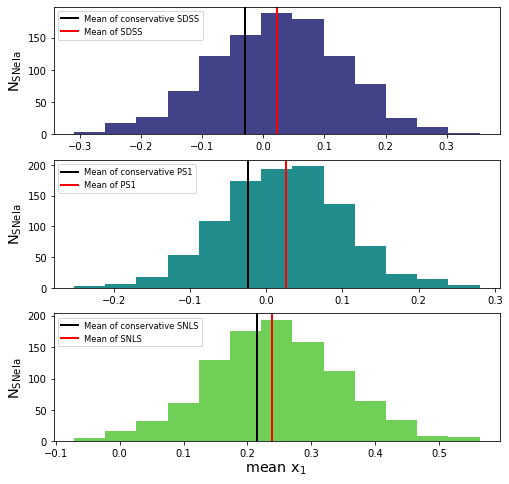

In [99]:
mean_ran = dict()
mean_cons = dict()

fig = plt.figure(figsize=[8, 8])

i = 1

for survey in surveys[1:-1]:
    mean_ran[survey] = np.asarray([np.mean(
        np.random.choice(x1_zcuts[survey],
                         len(z_zinfcuts[survey])))
                                   for i in range(1000)])
    mean_cons[survey] = np.mean(x1_zinfcuts[survey])

    ax = fig.add_subplot(int('31' + str(i)))

    ax.hist(mean_ran[survey], bins=13, color=colors[survey])

    ax.axvline(mean_cons[survey], lw=2, color='k', label='Mean of conservative ' + survey)
    ax.axvline(np.mean(x1_zcuts[survey]), lw=2, color='r', label='Mean of '+ survey)

    if i == 3:    
        ax.set_xlabel(r"$\mathrm{mean\,\,x_1}$ ", fontsize="x-large")
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

    ax.legend(loc='upper left',ncol=1, fontsize="small")
    
    #plt.title('Fraction of random SNe having mean < mean of conservative stretch = '
    #      + str(len(mean_ran[survey][np.where(mean_ran[survey] < mean_cons[survey])])))
    
    i+=1

fig=plt.gcf()
fig.savefig('../../../Images/monte_carlo_surveys.pdf', bbox_inches='tight')

In [100]:
for survey in surveys[1:-1]:
    print('Fraction of random ' + survey + ' stretchs being < mean_conservative =',
          len(mean_ran[survey][np.where(mean_ran[survey] < mean_cons[survey])])/len(mean_ran[survey]))

Fraction of random SDSS stretchs being < mean_conservative = 0.294
Fraction of random PS1 stretchs being < mean_conservative = 0.272
Fraction of random SNLS stretchs being < mean_conservative = 0.397
